<a href="https://colab.research.google.com/github/LeoPVL/video_style_transfer/blob/master/Video_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Style transfer - takes a very long time, but funny

In [ ]:
import tensorflow as tf
import IPython.display as display
import time
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
import numpy as np
import time
from pathlib import  Path

In [ ]:
def get_vgg_layers_model(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

def gram_matrix(input_tensor):
    """
    https://arxiv.org/pdf/1603.08155.pdf
    """
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    
    num_locations = tf.cast(input_shape[1]*input_shape[2]*input_shape[3], tf.float32)
    return result/(num_locations)

def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def load_img(path_to_img, max_dim=512):

    img = tf.io.read_file(path_to_img) # считываени файла
    img = tf.image.decode_image(img, channels=3)  # декодинг
    img = tf.image.convert_image_dtype(img, tf.float32) # uint8 -> float32, 255 -> 1
    
    shape = img.numpy().shape[:-1]
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tuple((np.array(shape) * scale).astype(np.int32))

    img = tf.image.resize(img, new_shape) # изменение размера
    img = img[tf.newaxis, :] # добавляем batch dimension
    return img

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.axis('off')
    plt.imshow(image)
    if title:
        plt.title(title)

def show_pair(original, generated, title=None):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    imshow(original, 'Original Image')
    plt.subplot(1, 2, 2)
    imshow(generated, title)

In [ ]:
class StyleAndContentExtractor:
    def __init__(self, style_layers, content_layers): 

        self.style_layers = style_layers
        self.content_layers = content_layers
        self.vgg_outputs_model = None
        self.vgg_outputs_model = get_vgg_layers_model(style_layers+content_layers)
        self.vgg_outputs_model.trainable = False
       
     def __call__(self, inputs):
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs*255.) # VGG препроцессинг
        outputs = self.vgg_outputs_model(preprocessed_input)
        features_dict = {}
        
        style_outputs = [gram_matrix(style_output) for style_output in outputs]
        content_outputs = [gram_matrix(content_output) for content_output in outputs]

        features_dict["style"] = {name:value for name, value in zip(self.style_layers, style_outputs)}
        features_dict["content"] = {name:value for name, value in zip(self.content_layers, content_outputs)}

     
        return features_dict

In [ ]:
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']
content_layers = ['block4_conv2'] 

extractor = StyleAndContentExtractor(style_layers=style_layers, content_layers=content_layers)
sample_image = np.ones((1, 512, 512, 3), dtype=np.float32)
style_and_content_targets = extractor(sample_image)

80142336/80134624 [==============================] - 3s 0us/step


In [ ]:
style_weight = 100.0
content_weight = 5.0
tv_weight = 0.1

In [ ]:
def style_content_loss(image, style_targets, content_targets): 

    style_loss = None
    content_loss = None

     
    current_features = extractor(image)
    style_loss = tf.add_n([tf.keras.losses.MeanSquaredError()(current_features['style'][name], style_targets[name]) 
                                     for name in current_features['style'].keys()])
    style_loss *= 1. / len(current_features)

    content_loss = tf.add_n([tf.keras.losses.MeanSquaredError()(current_features['content'][name], content_targets[name]) 
                                     for name in current_features['content'].keys()])
    content_loss *= 1. / len(current_features)

    loss = style_weight * style_loss + content_weight * content_loss + tv_weight * tf.image.total_variation(image)
    return loss

In [ ]:
def train_step(image, loss_func, optimizer):

    with tf.GradientTape() as tape: 
        loss = loss_func(image)
    grad = tape.gradient(loss, image) 
    optimizer.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image)) 
    return loss.numpy()

401408/395973 [==============================] - 0s 0us/step


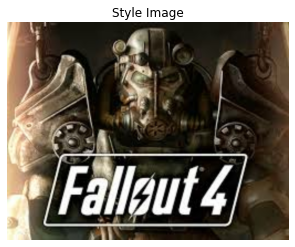

In [ ]:
# style_path = tf.keras.utils.get_file('krem.jpg','https://media-cdn.tripadvisor.com/media/photo-s/16/44/b4/17/red-square-and-kremlin.jpg')
# style_path = tf.keras.utils.get_file('klimt.jpg','https://images.huffingtonpost.com/2012-11-28-2klimtderkuss1908.jpeg')
# style_path = tf.keras.utils.get_file('lala2.jpg','https://thoughtcatalog.files.wordpress.com/2017/02/screen-shot-2017-02-06-at-12-40-06-pm.png')
# style_path = tf.keras.utils.get_file('starry.jpg','https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1280px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg')
# style_path = tf.keras.utils.get_file('2134.jpg','https://imgurl.argumenti.ru/news/news_id/20190719083652-621805.jpg')
# style_path = tf.keras.utils.get_file('goose.jpg','https://storage.googleapis.com/kaggle-avatars/images/default-thumb.png')
style_path = 'images.jpg'

style_image = load_img(style_path, 1024)

style_targets = extractor(style_image)['style']
plt.figure()
imshow(style_image, "Style Image")


In [ ]:
def transfer_style(content_image):
  def loss(image):
      return style_content_loss(image, style_targets, content_targets)
      
  image = tf.Variable(content_image) 
  content_targets = extractor(content_image)['content']
        
  opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
  epochs = 5
  steps_per_epoch = 50

  for n in range(epochs):
    for m in tqdm(range(steps_per_epoch)):
      train_step(image, loss_func=loss, optimizer=opt)
  plt.imsave("frame.png", image.numpy()[0],format  = 'png')


**Read and write video**

In [ ]:
from __future__ import print_function
import numpy as np
import cv2 
import argparse
import sys
from google.colab.patches import cv2_imshow
from IPython import display

In [ ]:
def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("-d", "--delay", type=int, default=1, help=" Time delay")
    parser.add_argument("-r", "--ref", type=str, default="test.mp4", help="Path to reference video")
    args, unknown = parser.parse_known_args()
    sourceReference = args.ref
    delay = args.delay
    framenum = -1 
    captRefrnc = cv2.VideoCapture(sourceReference)
    if not captRefrnc.isOpened():
        print("Could not open the reference " + sourceReference)
        sys.exit(-1)
    refS = (int(captRefrnc.get(cv2.CAP_PROP_FRAME_WIDTH)), int(captRefrnc.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    frame_width,frame_height = refS[0], refS[1]
    print("Reference frame resolution: Width={} Height={} of nr#: {}".format(frame_width, frame_height,
                                                                             captRefrnc.get(cv2.CAP_PROP_FRAME_COUNT)))
    out = cv2.VideoWriter('outpy.avi', apiPreference = 0, fourcc = cv2.VideoWriter_fourcc('M','J','P','G'), fps = 20, frameSize = (frame_width,frame_height))
    till_frame = 30
    while framenum<till_frame-1: 
        _, frameReference = captRefrnc.read()
        if frameReference is None:
            print(" < < <  Game over!  > > > ")
            break
        framenum += 1
        print(f'Frame {framenum+1} of {till_frame}')

        frameReference = cv2.cvtColor(frameReference, cv2.COLOR_BGR2RGB)
        plt.imsave("frame.png", frameReference,format  = 'png')
        img = load_img("frame.png", frame_width)
        
        cv2.waitKey(1)
        transfer_style(img)
        mat = cv2.imread("frame.png", cv2.IMREAD_COLOR)
        umat = cv2.UMat(mat)
        out.write(umat)

    out.release()
    

In [ ]:
if __name__ == "__main__":
    main()

Reference frame resolution: Width=1280 Height=720 of nr#: 1496.0
Frame 1 of 30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Frame 2 of 30



Frame 3 of 30



Frame 4 of 30



Frame 5 of 30



Frame 6 of 30



Frame 7 of 30



Frame 8 of 30



Frame 9 of 30



Frame 10 of 30



Frame 11 of 30



Frame 12 of 30



Frame 13 of 30



Frame 14 of 30



Frame 15 of 30



Frame 16 of 30



Frame 17 of 30



Frame 18 of 30



Frame 19 of 30



Frame 20 of 30



Frame 21 of 30



Frame 22 of 30



Frame 23 of 30



Frame 24 of 30



Frame 25 of 30



Frame 26 of 30



Frame 27 of 30



Frame 28 of 30



Frame 29 of 30



Frame 30 of 30
